In [1]:
#%pip install -U scikit-learn
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
import matplotlib.animation as animation
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KernelDensity
%matplotlib inline

In [2]:
# Definir parâmetros do dataset
T = 300  # Número total de observações
cluster_start = 600  # Tempo de início do intervalo de tempo do cluster
cluster_end = 800  # Tempo de fim do intervalo de tempo do cluster
cluster_proportion = 0.3  # Proporção de observações no cluster
tempo_maximo = 1000  # Tempo máximo para gerar os valores aleatórios

# Gerar o tempo (t)
np.random.seed(0)
times = np.random.randint(0, tempo_maximo, size=T)

# Gerar as coordenadas x, y de forma aleatória
np.random.seed(0)
x = np.random.uniform(0, 600, size=T)
y = np.random.uniform(0, 600, size=T)

# Criar um array de índices para selecionar as observações dentro do intervalo do cluster
cluster_indices = np.where((times >= cluster_start) & (times <= cluster_end))[0]

# Calcular o tamanho máximo do cluster com base na proporção desejada
cluster_size_max = int(T * cluster_proportion)

# Verificar se o número de observações no intervalo do cluster é menor ou igual ao tamanho máximo do cluster
if len(cluster_indices) <= cluster_size_max:
    selected_indices = cluster_indices
else:
    # Embaralhar os índices para garantir que selecione aleatoriamente o tamanho desejado
    np.random.shuffle(cluster_indices)

    # Selecionar os índices correspondentes ao tamanho máximo do cluster
    selected_indices = cluster_indices[:cluster_size_max]

# Criar a coluna "cluster" com base nos índices selecionados
is_cluster = np.zeros(T, dtype=bool)
is_cluster[selected_indices] = True

# Gerar as coordenadas x, y do cluster
cluster_x = np.random.normal(loc=100, scale=30, size=len(selected_indices))
cluster_y = np.random.normal(loc=200, scale=30, size=len(selected_indices))

# Criar cópias das coordenadas x, y para preservar as observações não cluster
x_clustered = np.copy(x)
y_clustered = np.copy(y)

# Substituir as coordenadas x, y pelo cluster nas observações dentro do intervalo
x_clustered[selected_indices] = cluster_x
y_clustered[selected_indices] = cluster_y

# Criar o DataFrame com as colunas x, y, t e cluster
df = pd.DataFrame({'x': x_clustered, 'y': y_clustered, 't': times, 'cluster': is_cluster})

# Exibir o DataFrame
df

,x,y,t,cluster
0,84.474429,228.102274,684,True
1,429.113620,464.428400,559,False
2,70.635104,242.369831,629,True
3,326.929910,48.660834,192,False
4,254.192880,244.344703,835,False
...,...,...,...,...
295,107.263539,216.299357,770,True
296,58.706691,217.313435,539,False
297,517.314910,282.389370,979,False
298,583.751693,226.947105,217,False


In [5]:
def criar_variaveis(df, rho=20, time_window=30):
    df[['var1']] = 0
    df[['var2']] = 0
    df[['var3']] = 0

    # Variável 1 - Distância Euclidiana
    for i in range(1, len(df)):
        a = np.array((df.loc[i, 'x'], df.loc[i, 'y']))
        b = np.array((df.loc[i - 1, 'x'], df.loc[i - 1, 'y']))
        df.loc[i, 'var1'] = np.linalg.norm(a - b)

    # Variável 2 - Densidade Espacial
    bandwidth = 0.1
    kde = KernelDensity(bandwidth=bandwidth, metric='haversine')
    for i in range(15, len(df)):
        current_point = np.array((df.loc[i, 'x'], df.loc[i, 'y']))
        filtered_data = df.loc[i - 15:i, ['x', 'y']].values

        if len(filtered_data) >= 2:
            kde.fit(np.radians(filtered_data))
            density = np.exp(kde.score_samples(np.radians([current_point])))[0]
            df.loc[i, 'var2'] = density

    # Variável 3 - Variação Temporal
    for i in range(15, len(df)):
        start_time = df.loc[i, 't'] - time_window
        end_time = df.loc[i, 't']
        filtered_data = df[(df['t'] >= start_time) & (df['t'] <= end_time)]

        df.loc[i, 'var3'] = len(filtered_data) - 1

    return df.drop(index=df.index[:15])

## MODELOS DE DETECTACAO 
outliers_fraction = 0.3
anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
]


In [6]:
B = 100
df_base = criar_variaveis(df.sort_values("t"))

# Dicionário para armazenar o tempo médio de duração de cada modelo
tempo_medio = {}

for name, algorithm in anomaly_algorithms:
    # Inicializar a coluna de contagem para cada modelo
    df_base[name] = 0
    
    # List para armazenar o tempo de duração de cada iteração do modelo
    tempos = []

    for b in range(B):
        # CRIANDO O BANCO DE DADOS b PARA TREINAR O MODELO
        df_b = df.copy()
        df_b['t'] = np.random.permutation(df_b['t'])
        df_b = criar_variaveis(df_b)
        df_b = df_b[['var1','var2','var3']]

        # INICIO DO TREINAMENTO DO MODELO
        t0 = time.time()

        # TREINO DO MODELO
        algorithm.fit(df_b.values)
        
        # TEMPO FINAL
        t1 = time.time()

        # PREDIZER OS OUTLIERS EM NA BASE ORIGINAL
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(df_base[['var1', 'var2', 'var3']].values)
        else:
            y_pred = algorithm.fit(df_b.values).predict(df_base[['var1', 'var2', 'var3']].values)
        
        # Atualizar a coluna de contagem para cada observação classificada como anomalia
        df_base[name] += (y_pred == -1).astype(int)
        
        # Armazenar o tempo de duração da iteração atual do modelo
        tempos.append(t1 - t0)
    
    # Calcular o tempo médio de duração do modelo
    tempo_medio[name] = np.mean(tempos)
    
    # Imprimir o tempo médio de duração do modelo
    print(f"{name} - Média de tempo de duração: {tempo_medio[name]:.2f}s")

One-Class SVM - Média de tempo de duração: 0.01s
One-Class SVM (SGD) - Média de tempo de duração: 0.01s
Isolation Forest - Média de tempo de duração: 0.18s


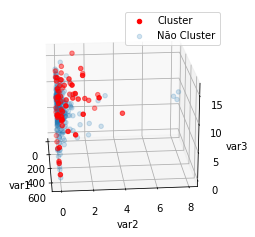

In [7]:
# Crie uma figura e um subplot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    # Plote os pontos pertencentes ao cluster em cor diferente
    ax.scatter(df_base[df_base['cluster'] == 1]['var1'], df_base[df_base['cluster'] == 1]['var2'], df_base[df_base['cluster'] == 1]['var3'], c='red', label='Cluster')
    # Plote os pontos não pertencentes ao cluster com maior transparência
    ax.scatter(df_base[df_base['cluster'] == 0]['var1'], df_base[df_base['cluster'] == 0]['var2'], df_base[df_base['cluster'] == 0]['var3'], alpha=0.2, label='Não Cluster')

    ax.set_xlabel('var1')
    ax.set_ylabel('var2')
    ax.set_zlabel('var3')
    ax.legend()

# Crie a animação
animation = FuncAnimation(fig, update, frames=72, interval=50)

# Salve a animação em formato de GIF
animation.save('teste.gif', writer='pillow')

# Mostrar o gráfico
plt.show()

In [8]:
df_base.to_csv('base_modelos_occ_anomalia04.csv', index=False)